In [1]:
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math

eng = matlab.engine.start_matlab()

In [538]:
quietDays = np.array(eng.quiet())
# Quiet days from 2009/09/5 to 2009/09/19
# quietDays[1580-1] = 2009/09/14

year = np.int16(quietDays[1580-1][0])
month = np.int16(quietDays[1580-1][1])
day = np.int16(quietDays[1580-1][2])
# year = 2010
# month = 9
# day = 6
hour = 0
minute = 0
second = 0
numberOfDaysWithData = 2


startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day+numberOfDaysWithData, hour, minute, second]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day+numberOfDaysWithData, hour, minute, second)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [539]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 540 ms, sys: 115 ms, total: 656 ms
Wall time: 3.44 s


In [494]:
%%time
from collections import OrderedDict

stationsYearMagPosition = OrderedDict(OrderedDict())
stationPosition = OrderedDict()  

for x in allMatData:  
    stationsYearMagPosition[str(x[1][0])] = OrderedDict()  
    try:
        for i in range(len(x[5][0])):
            stationPosition[x[5][0][i]] = x[9][0][i], x[10][0][i]
            stationsYearMagPosition[str(x[1][0])] = stationPosition.copy()
    except:
        print("no value")

CPU times: user 150 ms, sys: 63 ms, total: 213 ms
Wall time: 154 ms


In [540]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
    x=np.float32(dataSt.get("x")[timeshift])
#     x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
    y=np.float32(dataSt.get("y")[timeshift])
#     y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z=np.float32(dataSt.get("z")[timeshift])
#     z1=np.float32(dataSt.get("z1")[timeshift])
#     z2=np.float32(dataSt.get("z2")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = 1-abs(((math.sqrt(pow(x, 2)+pow(y, 2)+pow(z, 2)))/b[3])-1)
#     weight = gaussian(ratio, 1, 0)
    return np.round(x2,10), ratio

In [511]:
def AbsoluteValue(array):
    return (abs(max(array))+abs(min(array)))/2
def gaussian(x, a, b, c):
    return a*math.exp(-np.power((x-b),2)/(2*np.power(c,2)))


# x = np.linspace(-20, 20, 1000)
# fig= plt.figure(figsize=(20,8))
# axes= fig.add_axes([0.8,0.8,0.8,0.8])
# gauss = np.vectorize(gaussian)
# print(gaussian(15, 1, 0, AbsoluteValue(x)))
# axes.plot(x, gauss(x, 1, 0, AbsoluteValue(x)))
# plt.show()

In [541]:
%%time
stationIndicatorRatioVariation = defaultdict(list)
stationIndicatorVariation.clear()
numberOfMinutesNeededInTheTimeStamp = 1440
timeBetweenValues = 8
dataResolution = 0
dataBeforeNormalizaton = np.array([])

if 360%(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)==0:
    dataResolution = 360/(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)
    
    for st in allStationCodes:
#         st="mcq"
        delta = endDate-startDate
        totalMinutes = (delta.total_seconds()+1)/60
        for i in range(0, np.int16(totalMinutes), timeBetweenValues):
            try:
                update = datetime.timedelta(minutes=i)
                currentDate = startDate+update
                magneticValue, ratio = IndicatorCalculation(stationsOut.get(st), i, currentDate)
                stationIndicatorVariation[st].append(magneticValue)
                stationIndicatorRatioVariation[st].append(ratio)
            except:
                None
            
else:
    print("!ERROR! -- Your timeBetweenValues must be a multiple of the chosen time delta's amount of minutes -- !ERROR!")
    sys.exit



CPU times: user 48 s, sys: 2.76 s, total: 50.7 s
Wall time: 1min 12s


In [576]:
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
normalizedStationIndicatorVariation = defaultdict(list)
normalized01StationIndicatorVariation = defaultdict(list)
imp = Imputer(strategy="mean", axis=0)
scale = MinMaxScaler()
maxValueinDataset=0
minValueinDataset=0
def NormalizeDataGauss():
    for st in allStationCodes:
        for i in range(0, len(stationIndicatorVariation[st])):
            normalizedStationIndicatorVariation[st].append(gaussian(stationIndicatorVariation[st][i], 1, 0, AbsoluteValue(stationIndicatorVariation[st])))

def NormalizeData01():
    for st in allStationCodes:
        shapedValues = np.array(stationIndicatorVariation[st])
        if shapedValues.shape[0] != 0:
            if not math.isnan(stationIndicatorVariation[st][0]):
                a = imp.fit_transform(shapedValues.reshape(shapedValues.shape[0],1))
                transform = scale.fit_transform(a)
                normalized01StationIndicatorVariation[st].append(transform.reshape(transform.shape[0]))    

def normalizeWithGivenBounds(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]               

def ManuallyNormalizeData01():
    global maxValueinDataset
    global minValueinDataset
    max_values = np.array([])
    min_values = np.array([])
    max_values_ratio = np.array([])
    min_values_ratio = np.array([])
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
                max_values_ratio = np.append(max_values_ratio, max(stationIndicatorRatioVariation[st])) 
                min_values_ratio = np.append(min_values_ratio, min(stationIndicatorRatioVariation[st])) 
    
    totalMax = max(max_values)
    totalMin = min(min_values)
    totalMaxRatio = max(max_values_ratio)
    totalMinRatio = min(min_values_ratio)
    maxValueinDataset = totalMax
    minValueinDataset = totalMin
    
    bounds = np.array([0,1])   
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            localMax = max(stationIndicatorVariation[st])
            localMin = min(stationIndicatorVariation[st])
            localMaxRatio = max(stationIndicatorRatioVariation[st])
            localMinRatio = min(stationIndicatorRatioVariation[st])
            
            #When the ratio is far from the reference it's value tends to 0, when the ration corresponds to the reference the value tends to 1
            for i in range(0, len(stationIndicatorVariation[st])):
                stationIndicatorVariation[st][i] = stationIndicatorVariation[st][i]*stationIndicatorRatioVariation[st][i]
            normalized01StationIndicatorVariation[st] = normalizeWithGivenBounds(np.array(stationIndicatorVariation[st]), {'actual': {'lower': localMin, 'upper': localMax}, 'desired': {'lower': bounds[0], 'upper': bounds[1]}})



# NormalizeDataGauss()
# NormalizeData01()
ManuallyNormalizeData01()

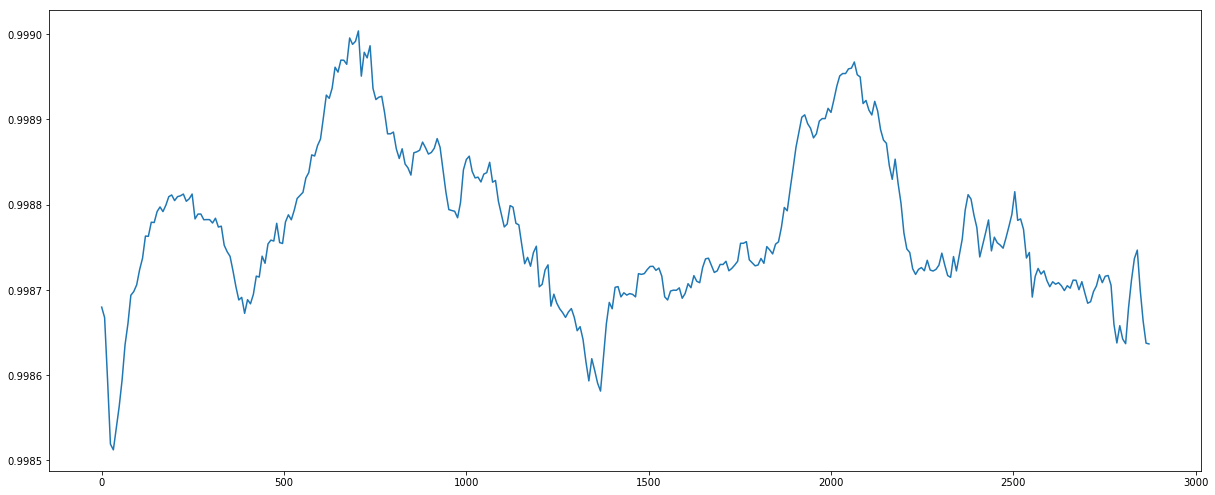

In [577]:
y = np.array(stationIndicatorRatioVariation["clf"])
x = np.arange(0, numberOfMinutesNeededInTheTimeStamp*numberOfDaysWithData, timeBetweenValues)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

In [573]:
def AdaptDimensions(vector, shape1):
    outputVector=np.array([])
    shift=shape1/vector.shape[0]
    for y in range(0, vector.shape[0]):
        for i in range(0, shift):
            outputVector = np.append(outputVector, vector[y])
    return outputVector

In [574]:
def indexValueOnLocalTime(array, st, i):
    numberOfValuesLong = numberOfMinutesNeededInTheTimeStamp/timeBetweenValues
    localTimeValuesArray = np.full((180, numberOfValuesLong), np.nan)
    long = float(stationsOut[st].get("longeo"))
    shiftValues = np.round((long*4)/timeBetweenValues,0)
    initialShiftValues = shiftValues
    z=0
    for y in range(numberOfValuesLong,array.shape[1]):
        if y+shiftValues>=array.shape[1]:
            localTimeValuesArray[i][np.int16(np.int16(y-(y-shiftValues+1)))] = array[i][numberOfValuesLong-z-1]
            shiftValues-=1
            z+=1
        else:
            localTimeValuesArray[i][np.int16(y+shiftValues)-numberOfValuesLong] = array[i][y]
            
    return localTimeValuesArray[i] 

In [578]:
indicatorVariationArray = np.full((180, (1440*numberOfDaysWithData)/timeBetweenValues), np.nan)
indicatorVariationArrayLocalTime = np.full((180, numberOfMinutesNeededInTheTimeStamp/timeBetweenValues), np.nan)


def makeIndicatorVariationArray(normalizedGauss, normalizedScaler):
    for st in allStationCodes:
#         st='clf'
        for i in range(-90, 90):
            if not isinstance(stationsOut[st], matlab.mlarray.double):
                if i == np.round(np.int16(stationsOut[st].get("latgeo")),0):
#                     if st=="aae": print i+90
#                     if i+90==138: print st
#                     print(st)
                    if normalizedScaler: 
                        indicatorVariationArray[i+90]=stationIndicatorRatioVariation[st]
                        indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(indicatorVariationArray, st, i+90)
                        
                    elif normalizedGauss: 
                        indicatorVariationArray[i+90]=AdaptDimensions(np.array(normalizedStationIndicatorVariation[st]), indicatorVariationArray.shape[1])
                    else: 
                        indicatorVariationArray[i+90]=AdaptDimensions(np.array(stationIndicatorVariation[st]), indicatorVariationArray.shape[1])
                else:
                    None
                    
makeIndicatorVariationArray(False,True)

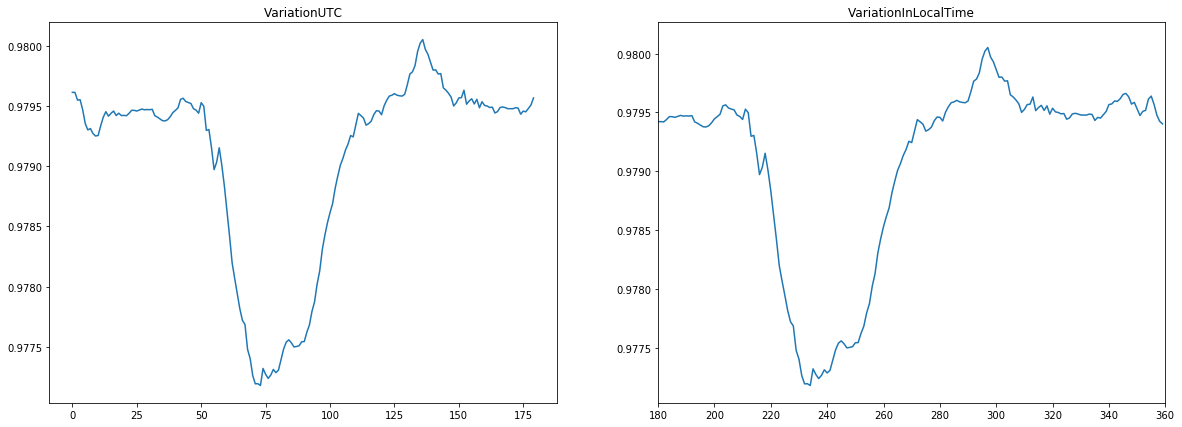

In [579]:
stationLat = 99
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,7)
x = np.arange(0,indicatorVariationArray[stationLat].shape[0],1)
x1 = np.arange(0,indicatorVariationArrayLocalTime[stationLat].shape[0],1)
ax1.set_title("VariationUTC")
ax2.set_title("VariationInLocalTime")
ax1.plot(x1.reshape(indicatorVariationArrayLocalTime[stationLat].shape[0],1), indicatorVariationArrayLocalTime[stationLat].reshape(indicatorVariationArrayLocalTime[stationLat].shape[0],1))
ax2.plot(x.reshape(indicatorVariationArray[stationLat].shape[0],1), indicatorVariationArray[stationLat].reshape(indicatorVariationArray[stationLat].shape[0],1))
# ax1.set_xbound(180,360)
ax2.set_xbound(180,360)

plt.show(fig)


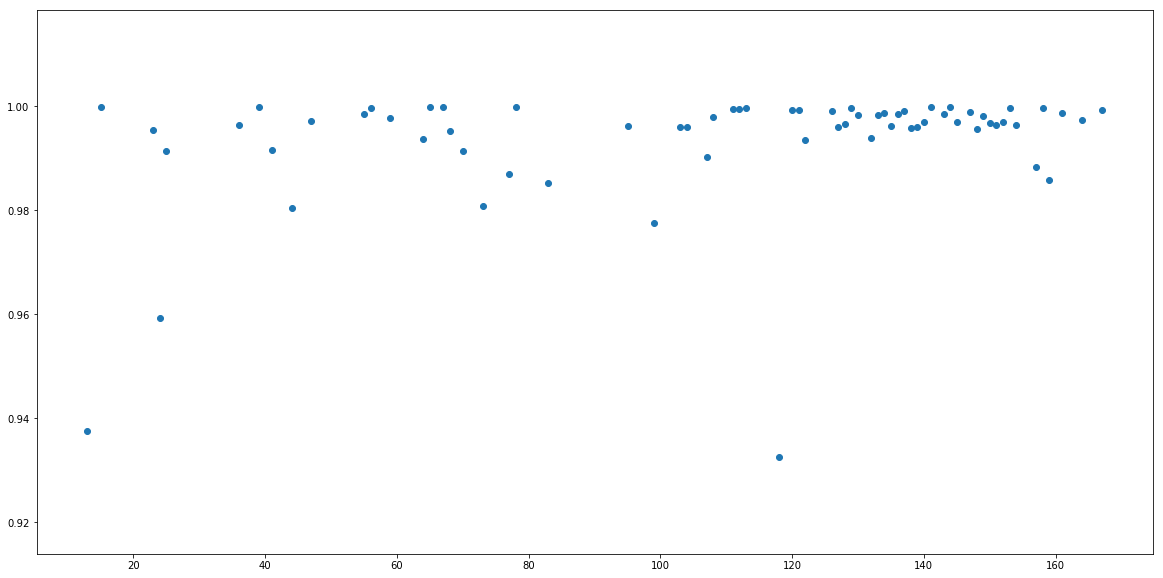

In [580]:
indicatorLatVariation = np.array([])
xLat =  np.array([])
for i in range(0, indicatorVariationArrayLocalTime.shape[0]):
    indicatorLatVariation = np.append(indicatorLatVariation, indicatorVariationArrayLocalTime[i][90])
    
xLat = np.arange(0, 180, 1).reshape(180, 1)
fig, ax1 = plt.subplots()

ax1.scatter(xLat, indicatorLatVariation.reshape(indicatorLatVariation.shape[0], 1))
fig.set_size_inches(20,10)

In [423]:
def PredictIndicatorForOneLatitude(wantedLatitude):
    timePrediction = np.full((360), np.inf)
    for i in range(0, 360, dataResolution):
        result = GetIndicatorLongPrediction(wantedLatitude,i)
        for y in range(i,i+dataResolution):
            timePrediction[y] = result
    return timePrediction

def AddTimePredictionToGlobal(prediction, latitude):
    indicatorVariationArray[latitude] = prediction
    
# AddTimePredictionToGlobal(PredictIndicatorForOneLatitude(90), 90)

In [569]:
ReconstructedArray = np.empty_like(indicatorVariationArrayIncreasedResolution)

def PredictIndicatorForAllLatitudes(baseArray):
    params = ParametersTuning(baseArray,baseArray.shape[1]/2)
#     params = ParametersTuningPoly(baseArray,baseArray.shape[1]/2)
    for i in range(0,baseArray.shape[0]):
        specificLatitudeTimePrediction = np.full((numberOfMinutesNeededInTheTimeStamp/timeBetweenValues), np.inf)
        if math.isinf(baseArray[i][0]) or math.isnan(baseArray[i][0]):
            for y in range(0,baseArray.shape[1],dataResolution):  
                print("Latitude index {} predicted out of {} in total, with hyper parameters {}".format(i, baseArray.shape[0],params))
                clear_output(wait=True)
                result = GetIndicatorLongPrediction(i,y,params,baseArray)
                for t in range(y,y+dataResolution):
                    specificLatitudeTimePrediction[t] = result
            ReconstructedArray[i] = specificLatitudeTimePrediction
        else:
            ReconstructedArray[i] = baseArray[i]

PredictIndicatorForAllLatitudes(indicatorVariationArrayIncreasedResolution)

Latitude index 539 predicted out of 540 in total, with hyper parameters {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}


In [ ]:
# np.savetxt("ReconstructedArray720x1.csv", ReconstructedArray, delimiter=",")
ReconstructedArray = np.empty_like(indicatorVariationArrayIncreasedResolution)

In [567]:
def IncreaseLatitudeResolution(array,resolutionValue):
    insertionArray = np.full((array.shape[0]*resolutionValue,numberOfMinutesNeededInTheTimeStamp/timeBetweenValues),np.nan)
    y=0
    for i in range(0, array.shape[0]):
        insertionArray[y] = array[i]
        y+=resolutionValue
    return insertionArray

indicatorVariationArrayIncreasedResolution = IncreaseLatitudeResolution(indicatorVariationArrayLocalTime,3)

In [158]:
def ZoomOnArray(zoomedArrayValueReference, latitudesAround):
    yResize = [zoomedArrayValueReference-latitudesAround, zoomedArrayValueReference+latitudesAround]
    plt.xlim(0,1440)
    plt.ylim(yResize[0], yResize[1])
    
    maxValues = np.array([])
    minValues = np.array([])
    
    if latitudesAround != 0:
        for i in range((yResize[0]+90)*4, (yResize[1]+90)*4):
            maxValues = np.append(maxValues, max(ReconstructedArray[i]))
            minValues = np.append(minValues, min(ReconstructedArray[i]))

        plt.clim(min(minValues), max(maxValues))
    else:
        plt.clim(min(ReconstructedArray[(zoomedArrayValueReference+90)*4]), max(ReconstructedArray[(zoomedArrayValueReference+90)*4]))

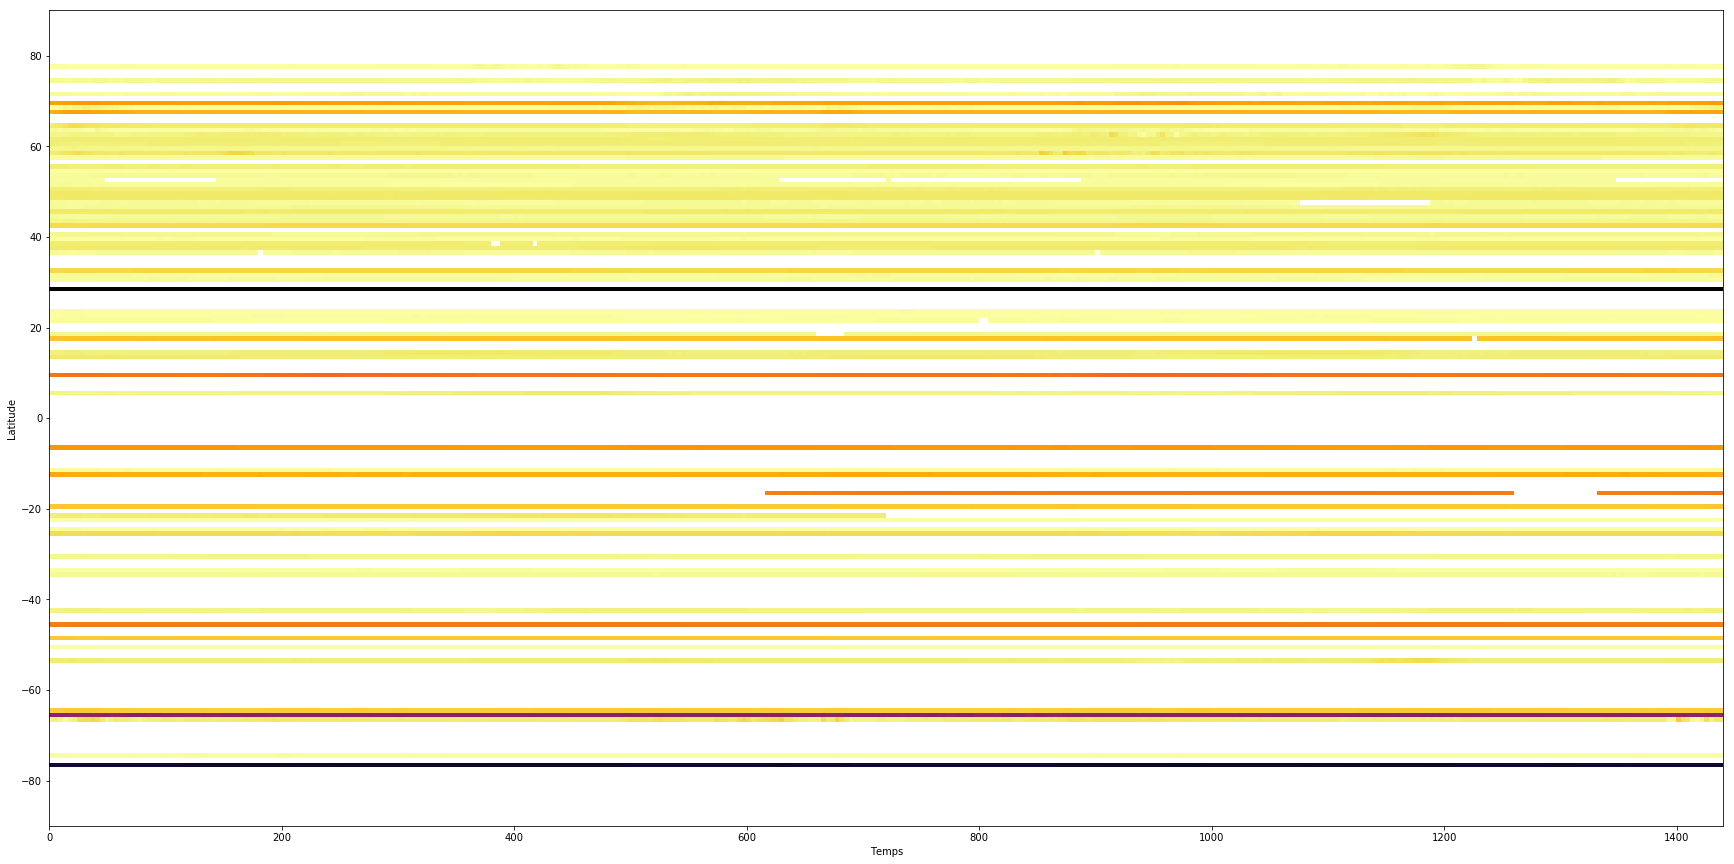

In [581]:
import matplotlib.cm as cm
fig= plt.figure(figsize=(30,15))
plt.imshow(indicatorVariationArray, origin='lower', cmap=plt.get_cmap("inferno"), aspect='auto', extent=[0,1440,-90,90])
#indicatorVariationArray, ReconstructedArray, indicatorVariationArrayIncreasedResolution, indicatorVariationArrayLocalTime
plt.xlabel("Temps")
plt.ylabel("Latitude")
# clb=plt.colorbar()
# sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("inferno"), norm=plt.Normalize(vmin=minValueinDataset, vmax=maxValueinDataset))
# sm._A = []
# plt.colorbar(sm)
# clb.ax.get_yaxis().set_ticks([0,1])
# clb.ax.get_yaxis().labelpad = 2
# clb.ax.text(1, 2, 1, ha='center', va='center')
# clb.ax.set_yticklabels(['0','1'])
# ZoomOnArray(60,5)
plt.savefig('OutputMatrix.png')
plt.show()

In [445]:
def GetIndicatorLongPrediction(latitude, longitude, params, baseArray):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][longitude])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)
    x,y = RemoveInfNan(x, y)
#     return PolyRegression(x,y,params).predict(latitude)
    return SupportVectorRegression(x,y,params).predict(latitude)

In [446]:
def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [447]:
from sklearn.svm import SVR

def SupportVectorRegression(latValues, indicatorValues,params):
    svr_rbf = SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
    model = svr_rbf.fit(latValues, indicatorValues)
    
    return model

def PolyRegression(latValues, indicatorValues,params):
    def PolynomialRegression(degree=2, **kwargs):
        return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

    poly_grid = PolynomialRegression(params)
    poly_grid.fit(latValues, indicatorValues)
    return poly_grid

In [448]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def ParametersTuning(baseArray,long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)

    x, y = RemoveInfNan(x, y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.scatter(X_train, y_train)
#     ax2.scatter(X_test, y_test)
#     fig.set_size_inches(15,5)
    
    parameters = {'kernel':['rbf'], 'gamma': [1e-5, 1e-4, 1e-3],'C': [1, 10, 50, 100]}
    svr = GridSearchCV(SVR(), parameters)
    svr.fit(X_train, y_train)
    print('score',svr.score(X_test, y_test))
    modelBestParams = svr.best_params_
    print ("Parameters tuning finished, best params: {}".format(modelBestParams))
    return modelBestParams

def ParametersTuningPoly(baseArray,long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)

    x, y = RemoveInfNan(x, y)
    
    params = {'polynomialfeatures__degree': np.arange(5,20,1), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
    poly_grid = GridSearchCV(PolynomialRegression(), params, cv=10, scoring='r2', verbose=1) #Scoring with coefficient of determination r2
    poly_grid.fit(x, y)
    print("Best hyper parameters found at: {}".format(poly_grid.best_params_))
    print("With {}% accuracy".format(poly_grid.best_score_))
    return poly_grid.best_params_

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  import sys


{'kernel': 'rbf', 'C': 100, 'gamma': 0.001}


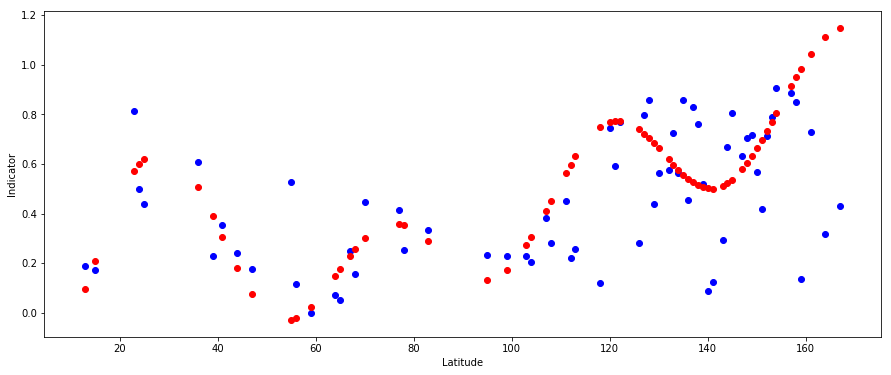

In [449]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

def printModelFitForGivenLong(baseArray, long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)
    

    x, y = RemoveInfNan(x, y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
    
    



    parameters = {'kernel':['rbf'], 'gamma': [1e-5, 1e-4, 1e-3],'C': [1, 10, 50, 100]}
    svr = GridSearchCV(SVR(), parameters)
    model=svr.fit(X_train, y_train)
    print svr.best_params_

    newPred = model.predict(X_test)

    
    
    plt.figure(figsize=(15,6))
    plt.xlabel("Latitude")
    plt.ylabel("Indicator")
    plt.scatter(x, y, c = 'blue')
    plt.scatter(x, model.predict(x), c='red')
    plt.show()
    
printModelFitForGivenLong(indicatorVariationArrayLocalTime, 120)

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  import sys


Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best hyper parameters found at: {'linearregression__normalize': False, 'polynomialfeatures__degree': 14, 'linearregression__fit_intercept': True}
With -0.846059948327% accuracy


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.8s finished


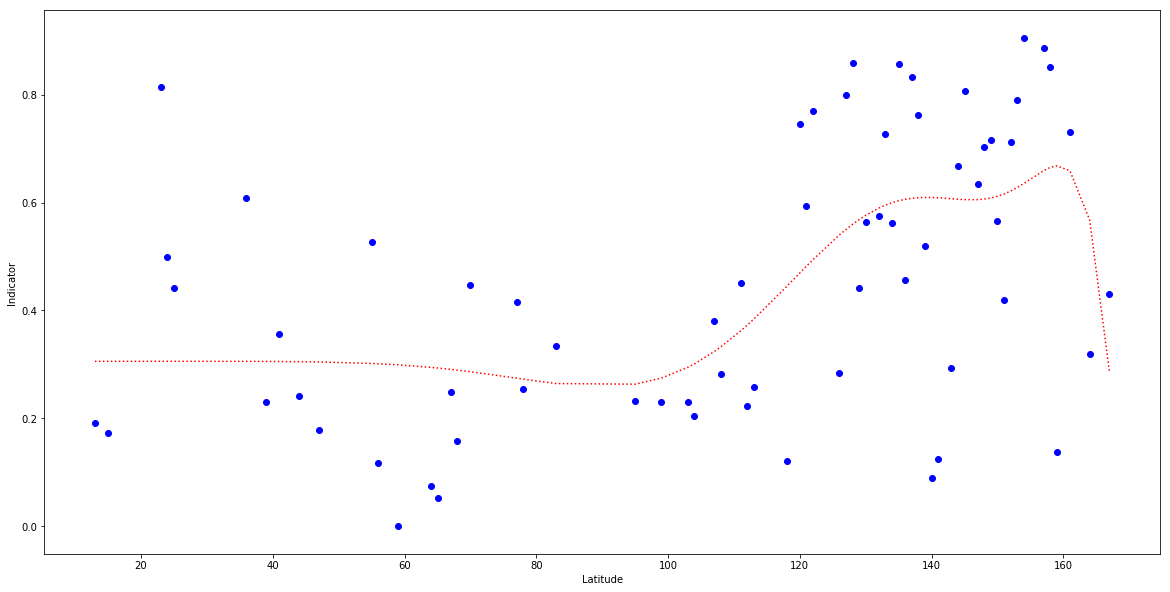

In [450]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

def printModelFitForGivenLong(baseArray, long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)
    

    x, y = RemoveInfNan(x, y)
#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
    
    
    def PolynomialRegression(degree=2, **kwargs):
        return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

    params = {'polynomialfeatures__degree': np.arange(5,20,1), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
    poly_grid = GridSearchCV(PolynomialRegression(), params, cv=10, scoring='r2', verbose=1) #Scoring with coefficient of determination r2
    poly_grid.fit(x, y)
    print("Best hyper parameters found at: {}".format(poly_grid.best_params_))
    print("With {}% accuracy".format(poly_grid.best_score_))
    
    
    
    plt.figure(figsize=(20,10))
    plt.xlabel("Latitude")
    plt.ylabel("Indicator")
    plt.scatter(x, y, c = 'blue')
    plt.plot(x, poly_grid.predict(x), "r:")
    plt.show()
    
printModelFitForGivenLong(indicatorVariationArrayLocalTime, 120)

